In [1]:
import pandas as pd
import torch

from PIL import Image
from dataclasses import dataclass
from torch.utils.data import Dataset
from pathlib import Path

In [ ]:
# 查看是否正确导入了chat数据
data_dir = './LLaVA-CC3M-Pretrain-595K'
chat_file = Path(data_dir).joinpath("chat.json")
chat_data = pd.read_json(chat_file)
# chat_data.head(10)

In [7]:
class LlavaDataset(Dataset):
    def __init__(self, dataset_dir: str) -> None:
        super().__init__()

        self.chat_data, self.image_dir = self.build_dataset(data_dir = dataset_dir)

    def build_dataset(self, data_dir: str) -> None:
        data_dir = Path(data_dir)
        chat_data = data_dir.joinpath("chat.json")
        image_dir = data_dir.joinpath("images")
        
        chat_data = pd.read_json(path_or_buf=chat_file).to_dict(orient='records')
        return chat_data, image_dir
    
    def __len__(self):
        return len(self.chat_data)
    # 用这个函数组合一个自己的数据格式，第一个元素为人类输入，第二个元素为GPT输出，第三个元素为图片路径
    # 这里的图片路径是相对于data_dir的
    def __getitem__(self, index):
        cur_data = self.chat_data[index]
        human_input = cur_data['conversations'][0]['value']
        gpt_output = cur_data['conversations'][1]['value']
        image_path = self.image_dir.joinpath(cur_data['image'])
        return (human_input, gpt_output, image_path)

In [12]:
# 对于所有对话数据构建自己定义的数据格式
test_llava = LlavaDataset(dataset_dir=data_dir)
# 查看数据集长度
len(test_llava)

595375

In [ ]:
# 查看第一个对话
test_llava[0]

('Provide a brief description of the given image.\n<image>',
 'olive oil is a healthy ingredient used liberally .',
 WindowsPath('LLaVA-CC3M-Pretrain-595K/images/GCC_train_002582585.jpg'))

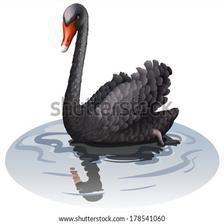

In [14]:
# 查看某个对话包含的图片，图片在第三个位置
Image.open(test_llava[12345][2]).convert("RGB")

In [15]:
from transformers import AutoProcessor
from transformers import LlavaNextProcessor
llava_model_name_or_path = "models/llava-v1.6-vicuna-7b-hf"
llava_processor = LlavaNextProcessor.from_pretrained(llava_model_name_or_path)

e:\Anaconda\envs\llava\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


ValueError: Cannot instantiate this tokenizer from a slow version. If it's based on sentencepiece, make sure you have sentencepiece installed.

In [17]:
from dataclasses import dataclass

@dataclass
class QaImageOutput:
    """
    LLaVA-Next 格式的对话消息输出
    """
    q_input_ids: torch.Tensor
    pixel_values: torch.Tensor
    image_size: torch.Tensor
    GPT_a: torch.Tensor

def build_qa_image(processor, human_input, gpt_output, image_path):
    """
    构建符合 LLaVA-Next 格式的对话消息
    
    参数:
    processor - LlavaNextProcessor 实例
    human_input - 用户输入文本
    gpt_output - 之前的模型回复 (用于多轮对话)
    image_path - 图片路径
    image_sizes - 图片尺寸
    返回:
    符合 LLaVA-Next 格式的提示字符串
    """
    # LLaVA-Next 使用固定的角色标识 "USER" 和 "ASSISTANT"
    # 图像标记 <image> 必须放在 USER 消息的开头
    
    # 构建多轮对话历史
    messages = []
    messages.append({"role": "USER", "content": f"{human_input}"})
    
    # 构建符合 LLaVA-Next 的提示字符串
    prompt = ""
    for msg in messages:
        if msg["role"] == "USER":
            prompt += f"USER: {msg['content']}\n"
        elif msg["role"] == "ASSISTANT":
            prompt += f"ASSISTANT: {msg['content']}</s>"
    
    # 添加 ASSISTANT: 提示模型生成回复
    prompt += "ASSISTANT:"
    
    image_file = image_path
    raw_image = Image.open(image_file)
    print(raw_image.size)
    inputs = processor(
        images=raw_image,
        text=prompt,
        return_tensors="pt",
    )
    # 将回答转换为ids
    gpt_a = processor(text=gpt_output,)

    return QaImageOutput(
        q_input_ids=torch.tensor(inputs.input_ids),
        pixel_values=torch.tensor(inputs.pixel_values),
        image_size=torch.tensor(inputs.image_sizes),
        GPT_a=torch.tensor(gpt_a.input_ids)
    )


In [18]:
# 测试构建的函数是否正确
test002 = test_llava[12345]
c = build_qa_image(llava_processor, 
               human_input=test002[0],
               gpt_output=test002[1],
               image_path=test002[2])
c.pixel_values.shape

NameError: name 'llava_processor' is not defined

In [ ]:
# decode GPT的回答
llava_processor.decode(c.GPT_a[0], skip_special_tokens=True)

In [ ]:
# 查看终止符， vicuna应该为2
llava_processor.tokenizer.eos_token_id

In [ ]:
# 训练数据集的collator
class TrainLLavaModelCollator:
    def __init__(self, processor:llava_processor, IGNORE_INDEX:int)-> None:

        self.processor = processor
        self.ignore_index = IGNORE_INDEX

    # 将单个对话转换为模型输入格式
    def convert_one_piece(self,
        q_input_ids:torch.Tensor,
        a_input_ids:torch.Tensor,) -> None:
     
        input_ids = torch.concat([
            q_input_ids,
            a_input_ids,
            torch.tensor([self.processor.tokenizer.eos_token_id]).reshape(1, 1)
        ], axis=1)

        # labels的构建
        # 这里的labels是为了计算loss，q_input_ids部分需要被忽略,用ignore_index填充
        labels = torch.concat([
            torch.full_like(q_input_ids, fill_value = self.ignore_index),
            a_input_ids,
            torch.tensor([self.processor.tokenizer.eos_token_id]).reshape(1, 1)
        ], axis=1)

        return input_ids, labels
    
    def __call__(self, features:list):

        # 定义最后多轮对话的输入格式
        input_ids_list = []
        labels_list = []
        pixel_values = []
        max_input_len_list = []
        # Llava-next一定要有image_sizes
        # 默认224x224
        image_sizes = []

        # 对于每轮对话包含三个元素：
        # 1. 人类输入文本
        # 2. GPT输出文本
        # 3. 图片路径
        # 这里的features是一个list，包含多个对话数据
        for feature in features:
            qaimage_output = build_qa_image(
                processor=self.processor,
                human_input=feature[0],
                gpt_output=feature[1],
                image_path=feature[2]
            )
            # 处理单轮对话数据
            temp_input_ids, temp_labels = self.convert_one_piece(
                q_input_ids=qaimage_output.q_input_ids,
                a_input_ids=qaimage_output.GPT_a
            )
            # 加入到列表中
            max_input_len_list.append(temp_input_ids.shape[1])
            input_ids_list.append(temp_input_ids)
            labels_list.append(temp_labels)
            pixel_values.append(qaimage_output.pixel_values)
            # 添加图像尺寸
            # 此数据集默认为224x224
            # 如果有其他尺寸的图像，可以在这里进行处理
            image_sizes.append([224, 224]) 
        # 计算最大输入长度
        max_input_len = max(max_input_len_list)
        # 对于每个输入，填充到最大长度
        final_input_ids = torch.concat([
            torch.concat(tensors=[
                torch.full(
                    size=(1, max_input_len - max_input_len_list[index]), 
                    fill_value=self.processor.tokenizer.pad_token_id),
                value,
            ], axis=1)
            for index, value in enumerate(input_ids_list)
        ])
        # 对于每个标签，填充到最大长度
        # 注意这里的labels需要忽略q_input_ids部分
        final_labels = torch.concat([torch.concat([
            torch.full(
                size=(1, max_input_len - max_input_len_list[index]), fill_value=self.ignore_index)
            , value
        ], axis=1) for index, value in enumerate(labels_list)])
        # 对于每个图像，concat成一个tensor
        final_pixel_values = torch.concat(pixel_values, axis=0)
        # 构建注意力掩码
        # 注意力掩码的构建，pad部分为0，非pad部分为1
        attention_mask = torch.ones_like(final_input_ids)
        attention_mask[final_input_ids == 
                       self.processor.tokenizer.pad_token_ids] = 0
    
        return {
                "input_ids": final_input_ids,
                "labels": final_labels,
                "pixel_values": final_pixel_values,
                "attention_mask": attention_mask,
                "image_sizes": image_sizes  
            }

In [ ]:
# 测试collator是否正确
tlmc = TrainLLavaModelCollator(
    processor=llava_processor,
    IGNORE_INDEX=-100
)
d = tlmc([test_llava[0], test_llava[1]])
d.keys()

In [19]:
# 检查显存是否充足
import torch
# 清空当前 PyTorch 占用的缓存
torch.cuda.empty_cache()
# 检查显存使用情况
print(f"当前显存占用: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"总显存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

当前显存占用: 0.00 MB
总显存: 11.99 GB


In [ ]:
from transformers import AutoProcessor, LlavaNextForConditionalGeneration
from transformers import LlavaNextProcessor
llava_model_name_or_path = "models/llava-v1.6-vicuna-7b-hf"
# llava_processor = LlavaNextProcessor.from_pretrained(llava_model_name_or_path)
llava_model = LlavaNextForConditionalGeneration.from_pretrained(llava_model_name_or_path,
    torch_dtype=torch.float16,
    device_map="cuda:0" )

In [ ]:
# 检查有无输出
model_output = llava_model(
        **d,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        output_scores=True,
        return_dict_in_generate=True    
    )
model_output.loss